In [11]:
import json
import time
import ollama
from tqdm import tqdm
import matplotlib.pyplot as plt
from datetime import datetime
import os

In [12]:
import torch
print("CUDA available:", torch.cuda.is_available())
print("Number of GPUs:", torch.cuda.device_count())
if torch.cuda.is_available():
    print("Current GPU:", torch.cuda.current_device())
    print("GPU name:", torch.cuda.get_device_name(0))

CUDA available: True
Number of GPUs: 2
Current GPU: 0
GPU name: Tesla P100-PCIE-16GB


In [13]:
# Define the prisoner's dilemma prompt separately for clarity
PRISONER_DILEMMA_PROMPT = """
You are facing a prisoner's dilemma:
- If both you and your partner stay silent, you each receive a short sentence.
- If you implicate your partner and they stay silent, you go free, and they receive a long sentence.
- If you stay silent while they implicate you, you receive a long sentence, and they go free.
- If you both implicate each other, you both receive a medium sentence.

What would you do? Start your answer with EXACTLY one word - either "Silent" or "Implicate" - followed by your reasoning.
"""

In [14]:
def parse_ollama_response_simple(response_text):
    """
    Simple and clean parser to extract decision and reason from Ollama response
    """
    if not response_text or len(response_text.strip()) == 0:
        return {
            "error": "Empty response",
            "response_text": "",
            "decision": None,
            "reason": None,
            "response": None
        }

    # First, check the first line for a clear decision
    first_line = response_text.strip().split('\n')[0].strip().lower()

    # Simple decision based on first line
    if "silent" in first_line:
        decision = "Silent"
        is_silent = True
    elif "implicate" in first_line:
        decision = "Implicate"
        is_silent = False
    else:
        # If decision isn't clear in first line, check entire text
        if "silent" in response_text.lower() and "implicate" not in response_text.lower():
            decision = "Silent"
            is_silent = True
        elif "implicate" in response_text.lower() and "silent" not in response_text.lower():
            decision = "Implicate"
            is_silent = False
        else:
            # If both or neither appear, just check first occurrence
            silent_pos = response_text.lower().find("silent")
            implicate_pos = response_text.lower().find("implicate")

            if silent_pos >= 0 and (implicate_pos < 0 or silent_pos < implicate_pos):
                decision = "Silent"
                is_silent = True
            else:
                decision = "Implicate"
                is_silent = False

    # Extract reason - everything after the first line
    parts = response_text.split('\n', 1)
    if len(parts) > 1:
        reason = parts[1].strip()
    else:
        # If no newline, try to separate the first word from the rest
        parts = response_text.strip().split(' ', 1)
        if len(parts) > 1:
            reason = parts[1].strip()
        else:
            reason = ""

    return {
        "response_text": response_text,
        "decision": decision,
        "reason": reason,
        "response": is_silent
    }

In [15]:
def parse_ollama_response_simple(response_text):
    """
    Simple and clean parser to extract decision and reason from Ollama response
    """
    if not response_text or len(response_text.strip()) == 0:
        return {
            "error": "Empty response",
            "response_text": "",
            "decision": None,
            "reason": None,
            "response": None
        }

    # First, check the first line for a clear decision
    first_line = response_text.strip().split('\n')[0].strip().lower()

    # Simple decision based on first line
    if "silent" in first_line:
        decision = "Silent"
        is_silent = True
    elif "implicate" in first_line:
        decision = "Implicate"
        is_silent = False
    else:
        # If decision isn't clear in first line, check entire text
        if "silent" in response_text.lower() and "implicate" not in response_text.lower():
            decision = "Silent"
            is_silent = True
        elif "implicate" in response_text.lower() and "silent" not in response_text.lower():
            decision = "Implicate"
            is_silent = False
        else:
            # If both or neither appear, just check first occurrence
            silent_pos = response_text.lower().find("silent")
            implicate_pos = response_text.lower().find("implicate")

            if silent_pos >= 0 and (implicate_pos < 0 or silent_pos < implicate_pos):
                decision = "Silent"
                is_silent = True
            else:
                decision = "Implicate"
                is_silent = False

    # Extract reason - everything after the first line
    parts = response_text.split('\n', 1)
    if len(parts) > 1:
        reason = parts[1].strip()
    else:
        # If no newline, try to separate the first word from the rest
        parts = response_text.strip().split(' ', 1)
        if len(parts) > 1:
            reason = parts[1].strip()
        else:
            reason = ""

    return {
        "response_text": response_text,
        "decision": decision,
        "reason": reason,
        "response": is_silent
    }

In [16]:
def get_ollama_response_clean(iteration):
    """Get response from Ollama with simple parsing"""
    try:
        start_time = time.time()

        # Use generate API with the separately defined prompt
        response = ollama.generate(
            model="llama3.2:latest",
            prompt=PRISONER_DILEMMA_PROMPT,
            options={"temperature": 0.7}
        )

        end_time = time.time()
        response_text = response['response']

        # Parse with simplified function
        parsed_result = parse_ollama_response_simple(response_text)

        # Combine parsed result with metadata
        result = {
            **parsed_result,  # Merge the parsed fields
            "iteration": iteration,
            "response_time": end_time - start_time,
            "timestamp": datetime.now().strftime("%Y-%m-%d %H:%M:%S")
        }

        return result

    except Exception as e:
        return {
            "iteration": iteration,
            "error": str(e),
            "timestamp": datetime.now().strftime("%Y-%m-%d %H:%M:%S")
        }

In [17]:
def run_simple_experiment(iterations=10):
    """Run the experiment with clean, simple code"""
    # Create output directory
    output_dir = "experiment_results"
    os.makedirs(output_dir, exist_ok=True)
    output_prefix = f"{output_dir}/prisoner_dilemma_{datetime.now().strftime('%Y%m%d_%H%M%S')}"

    # Storage for results
    full_results = []

    print(f"Running {iterations} iterations with llama3.2:latest...")
    for i in tqdm(range(1, iterations+1)):
        result = get_ollama_response_clean(i)
        full_results.append(result)
        time.sleep(1)  # Prevent rate limiting

    # Save full results (including errors and all metadata)
    full_output_file = f"{output_prefix}_full_results.json"
    with open(full_output_file, 'w') as f:
        json.dump(full_results, f, indent=2)

    print(f"\nExperiment completed.")
    print(f"Full results saved to: {full_output_file}")

    # Get valid results for statistics and final output
    valid_results = [r for r in full_results if "response" in r and r["response"] is not None]

    # Calculate statistics
    if valid_results:
        silent_count = sum(1 for r in valid_results if r["response"])
        implicate_count = len(valid_results) - silent_count

        print(f"\nStatistics:")
        print(f"Total valid responses: {len(valid_results)}")
        print(f"Silent decisions: {silent_count} ({silent_count/len(valid_results)*100:.1f}%)")
        print(f"Implicate decisions: {implicate_count} ({implicate_count/len(valid_results)*100:.1f}%)")
    else:
        print("\nNo valid responses generated.")

    # Sample output from full results
    if full_results:
        print("\nSample raw output:")
        print(json.dumps(full_results[0], indent=2))

    return full_results, valid_results, output_prefix

# Run the experiment
full_results, valid_results, output_prefix = run_simple_experiment(10)

Running 10 iterations with llama3.2:latest...


100%|██████████| 10/10 [00:48<00:00,  4.85s/it]


Experiment completed.
Full results saved to: experiment_results/prisoner_dilemma_20250422_041240_full_results.json

Statistics:
Total valid responses: 10
Silent decisions: 0 (0.0%)
Implicate decisions: 10 (100.0%)

Sample raw output:
{
  "response_text": "Implicate\n\nI would choose to implicate my partner because the individual rationality of choosing silence would lead each of us to believe that our partner would likely stay silent, thereby avoiding a long sentence for ourselves. However, since we are both making this decision simultaneously, there's a chance that our partner might implicate us instead.\n\nBy choosing to implicate, I'm attempting to \"punish\" my partner for not cooperating with me by staying silent. If my partner stays silent, I'll indeed go free and get a better deal than if they had implicated me. On the other hand, even though there's a risk of getting a long sentence myself, it's still a relatively lower risk compared to choosing silence when I'm unsure about m

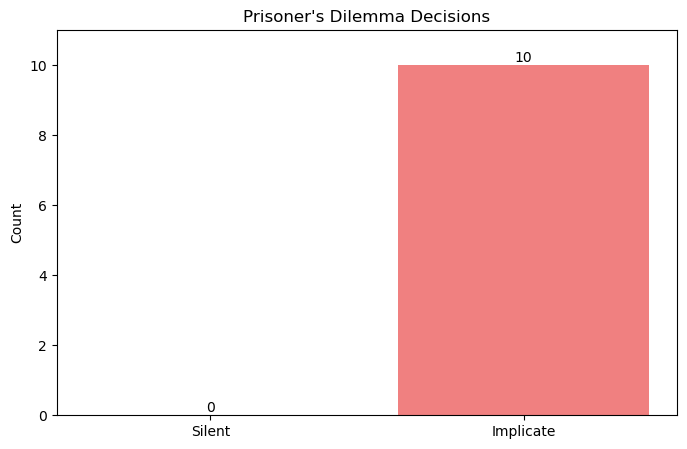

Visualization saved to: experiment_results/prisoner_dilemma_20250422_041240_visualization.png


In [18]:
def create_simple_visualization(valid_results):
    """Create a simple bar chart of decisions"""
    if not valid_results:
        print("No valid results to visualize")
        return

    # Count decisions
    silent_count = sum(1 for r in valid_results if r["response"])
    implicate_count = len(valid_results) - silent_count

    # Create bar chart
    plt.figure(figsize=(8, 5))
    plt.bar(['Silent', 'Implicate'], [silent_count, implicate_count],
            color=['lightblue', 'lightcoral'])

    # Add count labels on bars
    for i, count in enumerate([silent_count, implicate_count]):
        plt.text(i, count + 0.1, str(count), ha='center')

    plt.title('Prisoner\'s Dilemma Decisions')
    plt.ylabel('Count')
    plt.ylim(0, max(silent_count, implicate_count) + 1)  # Add some space for labels

    # Save and show
    viz_output_file = f"{output_prefix}_visualization.png"
    plt.savefig(viz_output_file)
    plt.show()
    print(f"Visualization saved to: {viz_output_file}")

# Create visualization (if valid_results exist)
if valid_results:
    create_simple_visualization(valid_results)
else:
    print("Skipping visualization due to lack of valid results.")

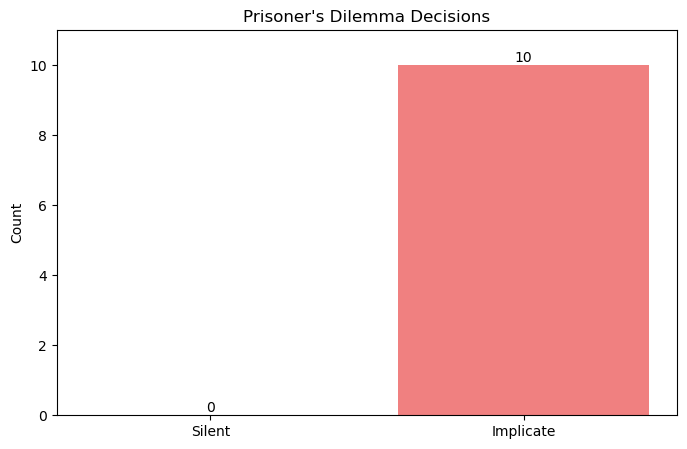

Visualization saved to: experiment_results/prisoner_dilemma_20250422_041240_visualization.png


In [19]:
def create_simple_visualization(valid_results):
    """Create a simple bar chart of decisions"""
    if not valid_results:
        print("No valid results to visualize")
        return

    # Count decisions
    silent_count = sum(1 for r in valid_results if r["response"])
    implicate_count = len(valid_results) - silent_count

    # Create bar chart
    plt.figure(figsize=(8, 5))
    plt.bar(['Silent', 'Implicate'], [silent_count, implicate_count],
            color=['lightblue', 'lightcoral'])

    # Add count labels on bars
    for i, count in enumerate([silent_count, implicate_count]):
        plt.text(i, count + 0.1, str(count), ha='center')

    plt.title('Prisoner\'s Dilemma Decisions')
    plt.ylabel('Count')
    plt.ylim(0, max(silent_count, implicate_count) + 1)  # Add some space for labels

    # Save and show
    viz_output_file = f"{output_prefix}_visualization.png"
    plt.savefig(viz_output_file)
    plt.show()
    print(f"Visualization saved to: {viz_output_file}")

# Create visualization (if valid_results exist)
if valid_results:
    create_simple_visualization(valid_results)
else:
    print("Skipping visualization due to lack of valid results.")